### Ниже - учебный кейс по проведению A/B-теста в рамках курса Аналитик Данных, Karpov Courses.

Текст заданий и их порядок сформулированы на курсе. По этой причине логика повествования иногда скачет, т.к. необходимо соблюдать порядок выполнения заданий.

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

In [60]:
# Импорт библиотек и ввод настроек
import pandas as pd
import numpy as np
import scipy
import requests
from urllib.parse import urlencode
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale = 1.5, style = 'whitegrid', rc = {'figure.figsize' : (20,8)})

In [3]:
# Загрузка данных

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/IRS2XlvJAteTmA' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
orders = pd.read_csv(download_url)

print(orders.shape)
orders.head(2)

(20196, 4)


,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control


Ознакомимся с данными. Посмотрим типы данных, наличие пропущенных значений.

Колонки нашего датафрейма:
- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа

In [4]:
orders.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [5]:
orders.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [6]:
orders.nunique()

order_id            20196
delivery_time          72
district                3
experiment_group        2
dtype: int64

In [8]:
orders.experiment_group.value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

Задание 1.

Сформулируем гипотезы. 

- Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.
- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Задание 2. 

Начнем работу с данными в группах. Для начала, визуализируем распределение времени доставки в тестовой группе и контрольной группе. Учтем в распределении район, в который осуществляется доставка.

In [22]:
test_group = orders.query('experiment_group == "test"')
control_group = orders.query('experiment_group == "control"')

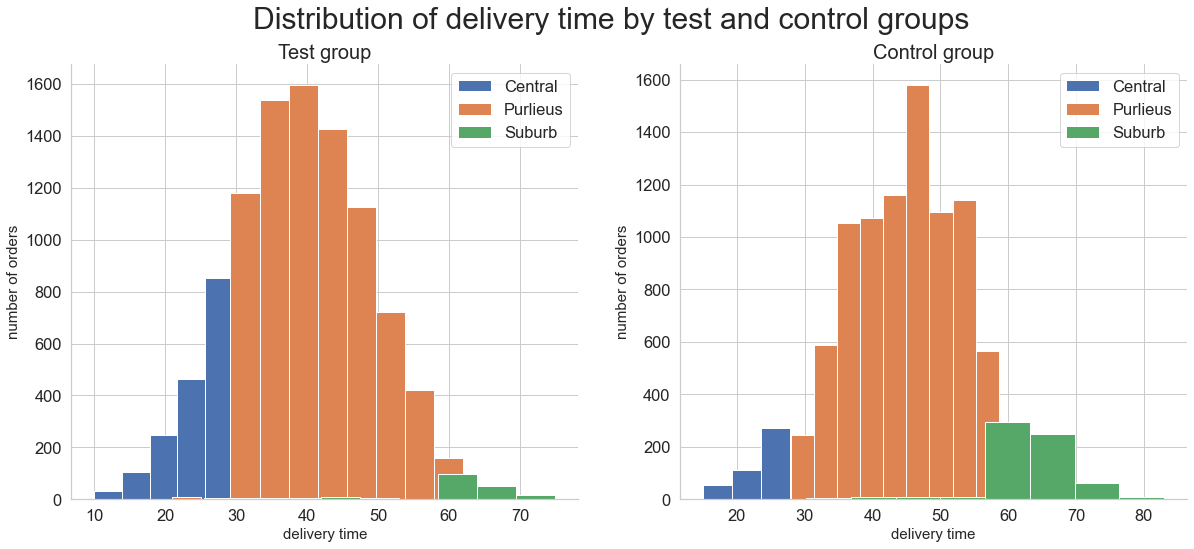

In [47]:
fig, axes = plt.subplots(1,2,figsize = (20, 8))

test_group.groupby('district').delivery_time.hist(ax = axes[0], legend = True)
control_group.groupby('district').delivery_time.hist(ax = axes[1], legend = True)
fig.suptitle('Distribution of delivery time by test and control groups', fontsize = 30)
axes[0].set_title('Test group', fontsize = 20)
axes[0].set_xlabel('delivery time', fontsize = 15)
axes[0].set_ylabel('number of orders', fontsize = 15)
axes[1].set_title('Control group', fontsize = 20)
axes[1].set_xlabel('delivery time', fontsize = 15)
axes[1].set_ylabel('number of orders', fontsize = 15)
sns.despine()

По данным распределениям преждевременно делать конкретные выводы, но некоторые наблюдения уже можно сделать. 

- В обоих случаях мы видим характер распределения, имеющий признаки нормального распределения.
- Мы видим схожие порядки у наших колличественных значений. При этом уже есть признаки отличий в значениях.
- В тестовой группе мы наблюдаем признаки перераспределения доставок по районам Central и Suburb.

Зафиксируем некоторые колличественные параметры.

In [96]:
test_mean_time = test_group.delivery_time.mean()
test_mean_time

39.04681314330958

In [97]:
test_median_time = test_group.delivery_time.median()
test_median_time

39.0

In [98]:
control_mean_time = control_group.delivery_time.mean()
control_mean_time

45.065101070154576

In [99]:
control_median_time = control_group.delivery_time.median()
control_median_time

45.0

Помимо визуального распределения, мы можем видеть близость значений среднего времени доставки и медианного времени доставки внутри каждой группы. Это позволит нам не беспокоиться о выборе меры центральной тенденции в наших расчетах и спокойно использовать среднее значение.

Также нельзя не заметить отличие значений тестовой и контрольной группы. Позднее мы к этому вернемся.

Задание 3.

Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [100]:
print(test_group.shape[0] - control_group.shape[0])

12


Задание 4.

Изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в группах.

Получим p-value для следующего утверждения "Данная выборка распределения времени доставки является частью нормального распределения". Для того, чтобы проверить нормальность распределения, я использую тест Агостино-Пирсона по функции scipy.stats.normaltest().

In [101]:
print('P-value для тестовой группы -',
    round(scipy.stats.normaltest(test_group.delivery_time)[1],5))
test_sd = test_group.delivery_time.std()
print('Стандартное отклонение времени доставки тестовой группы -', round(test_sd,2))

P-value для тестовой группы - 0.02983
Стандартное отклонение времени доставки тестовой группы - 9.88


In [102]:
print('P-value для контрольной группы -',
    round(scipy.stats.normaltest(control_group.delivery_time)[1],5))
control_sd = control_group.delivery_time.std()
print('Стандартное отклонение времени доставки тестовой группы -', round(control_sd,2))

P-value для контрольной группы - 0.88095
Стандартное отклонение времени доставки тестовой группы - 9.99


Задание 4. 

Сравнить средние значения в тестовой группе и в контрольной группе.

Мы видим, что вероятность для распределения тестовой группы быть извлеченной из нормального распределения крайне мала. Однако, принимая во внимание довольно близкие параметры изменчивости распределений, их унимодальность, симметричность, а главное - большое количество заказов в наших выборках - позволим себе применить критерий Стьюдента для сравнения средних значений в наших группах.

In [103]:
scipy.stats.ttest_ind(control_group.delivery_time, test_group.delivery_time)

Ttest_indResult(statistic=43.03582663183714, pvalue=0.0)

Критерий Стьюдента говорит нам о том, что вероятность получить такое или еще более ярковыраженное отличие между средними значениями контрольной и тестовой группе, при условии что они принадлежат одной генеральной совокупности, стремится к нулю. Следовательно, мы можем отвергнуть нулевую гипотезу о равенстве средних и сказать что отличие между средними значениями существует, и оно статистически значимо.

Задание 5.

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

In [107]:
print('Среднее время доставки заказов в тестовой группе изменилось на ',
      round(100*(test_mean_time - control_mean_time)/ control_mean_time,2), '%')

Среднее время доставки заказов в тестовой группе изменилось на  -13.35 %


Итого, можем сделать вывод о том, что новый алгоритм положительно влияет на скорость доставки, и функцию доставки заказов "по пути домой" стоит распространить на всех наших сотрудников.